In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
df = pd.read_csv(df_path, sep="\t")

In [3]:
from eppi_text_classification import (
    get_features_and_labels,
    get_tfidf_and_names,
)

word_features, labels = get_features_and_labels(df)

tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [5]:
from eppi_text_classification import OptunaHyperparameterOptimisation
from eppi_text_classification.utils import delete_optuna_study

optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "XGBClassifier",
    n_trials_per_job=10,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
)

delete_optuna_study("xgb_binary")
best_params = optimiser.optimise_hyperparameters(study_name="xgb_binary")

[I 2024-06-22 11:49:00,843] A new study created in RDB with name: xgb_binary
[I 2024-06-22 11:49:03,688] Trial 7 finished with value: 0.6004903046813196 and parameters: {'reg_lambda': 11.539224328552082, 'reg_alpha': 61.46512837016794, 'learning_rate': 63.10149518875004, 'max_depth': 1}. Best is trial 7 with value: 0.6004903046813196.
[I 2024-06-22 11:49:03,779] Trial 3 finished with value: 0.7367386437956283 and parameters: {'reg_lambda': 0.18157154187343624, 'reg_alpha': 5.778542334172558, 'learning_rate': 58.08580162330662, 'max_depth': 3}. Best is trial 3 with value: 0.7367386437956283.
[I 2024-06-22 11:49:03,829] Trial 10 finished with value: 0.786378950160727 and parameters: {'reg_lambda': 1.4565797331606145, 'reg_alpha': 0.03610395572261504, 'learning_rate': 24.01980393970274, 'max_depth': 4}. Best is trial 10 with value: 0.786378950160727.
[I 2024-06-22 11:49:03,962] Trial 1 finished with value: 0.731440322434851 and parameters: {'reg_lambda': 0.03744963493761846, 'reg_alpha': 

In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# model = XGBClassifier(**best_params)

model = model = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    colsample_bytree=1,
    n_jobs=-1,
    scale_pos_weight=42,
    reg_lambda=0.017636592766577953,
    reg_alpha=0.03834292094431529,
    learning_rate=0.4507787503025981,
    n_estimators=557,
    gamma=6.384905359051449e-10,
    max_depth=2,
)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=7
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=6.384905359051449e-10, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4507787503025981, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=557, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [36]:
from eppi_text_classification.predict import predict_probabilities
from eppi_text_classification.plotly_roc import plotly_roc

y_test_pred_probs = predict_probabilities(model, X_test)
plotly_roc(y_test, y_test_pred_probs)

In [38]:
from eppi_text_classification.predict import (
    get_threshold,
    threshold_predict,
)


threshold = get_threshold(model, X_test, y_test, target_tpr=1)

y_test_pred = threshold_predict(model, X_test, threshold)
y_train_pred = threshold_predict(model, X_train, threshold)

In [39]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

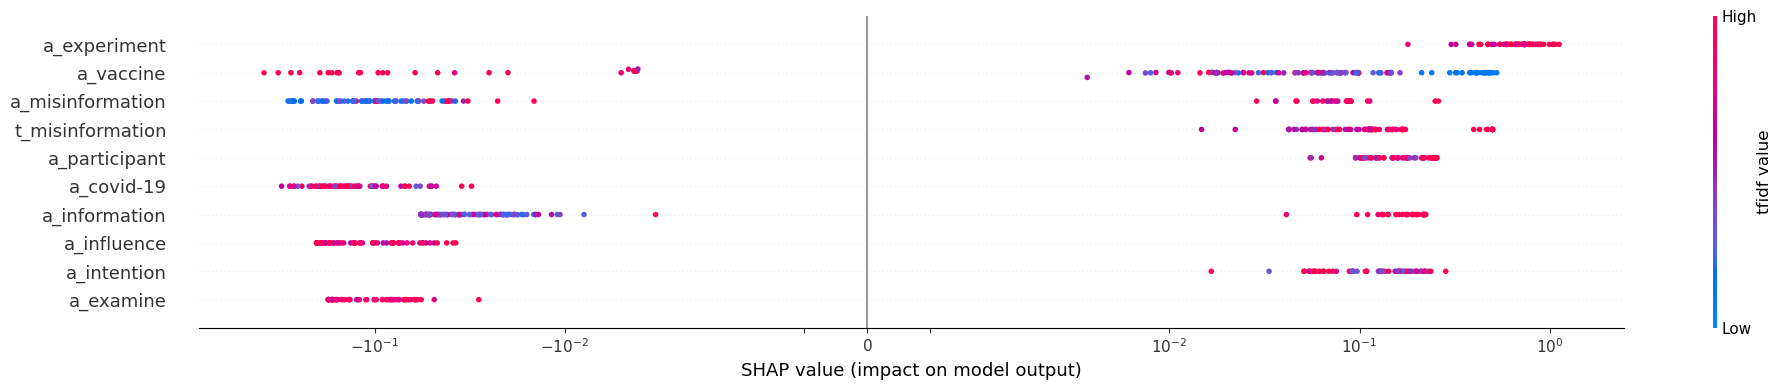

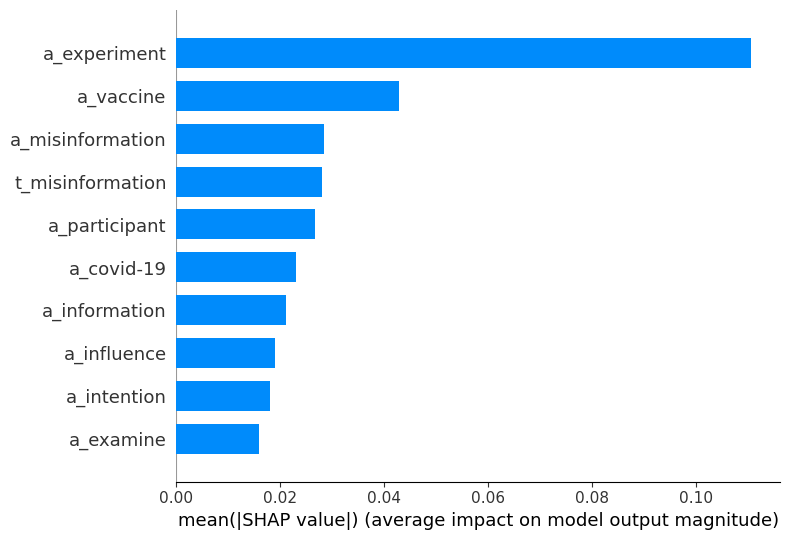

In [40]:
from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(model, X_test, feature_names)

shap_plotter.dot_plot(num_display=10)
shap_plotter.bar_chart()

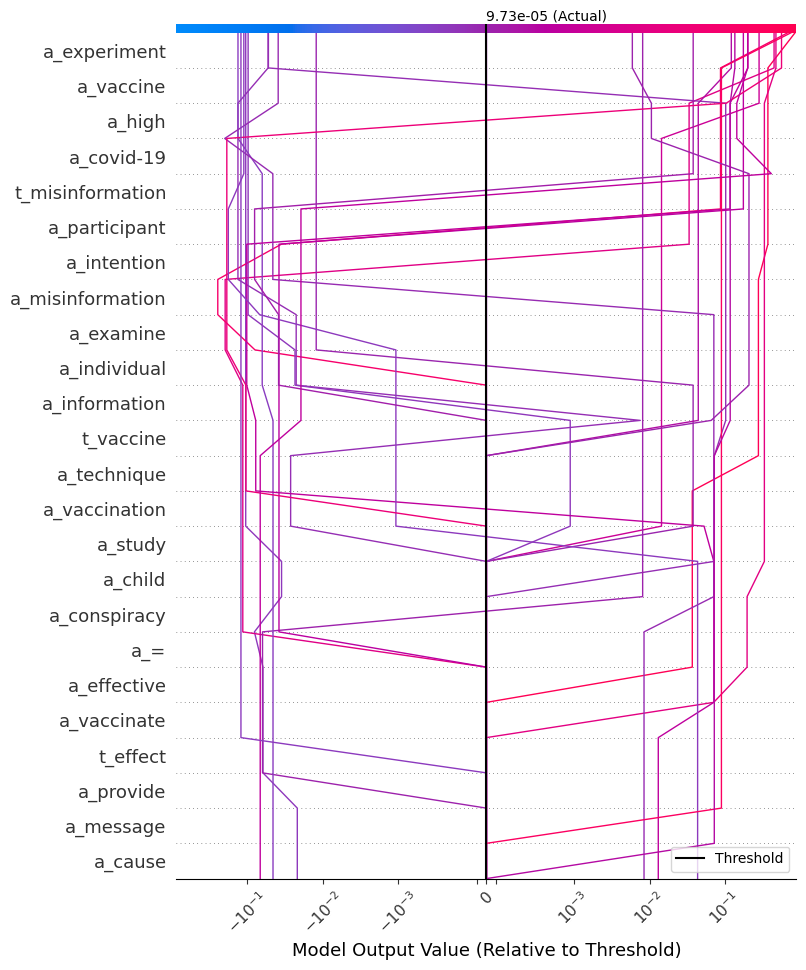

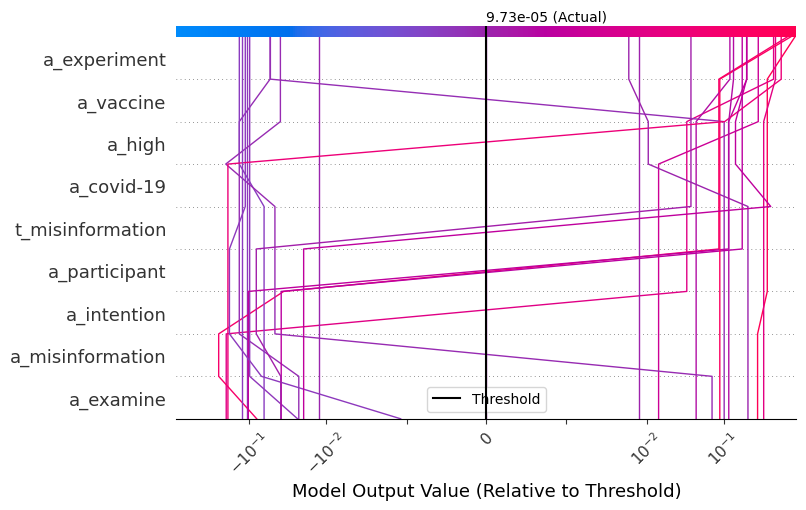

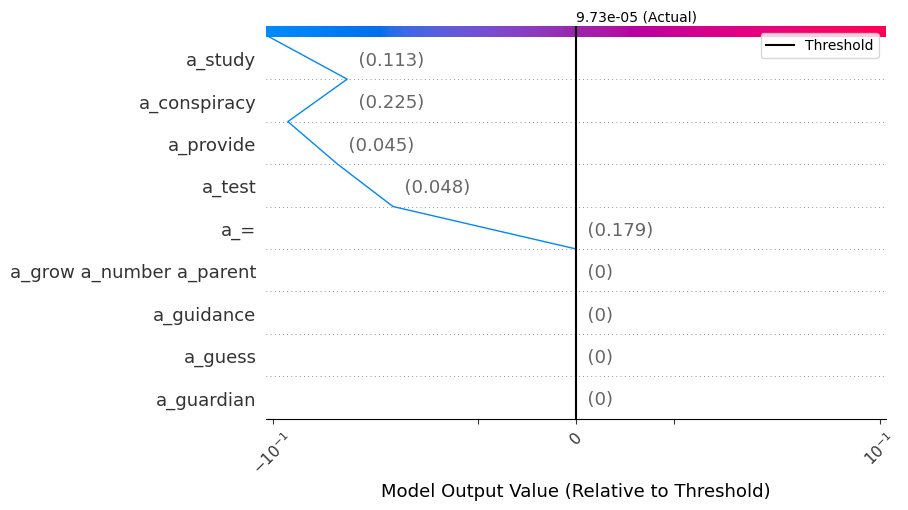

In [41]:
shap_plotter = ShapPlotter(model, X_test[:25], feature_names)

shap_plotter.decision_plot(threshold=threshold, num_display=25)
shap_plotter.decision_plot(threshold=threshold, num_display=10)
shap_plotter.single_decision_plot(threshold=threshold, index=0, num_display=10)

array([[9.9997902e-01, 2.0971094e-05]], dtype=float32)